In [2]:
import osmnx
import geopandas as gpd
import gpxpy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, mapping, Point
import matplotlib.image as mpimg
import rasterio
from rasterio.merge import merge
from rasterio import mask as msk
from rasterio.transform import Affine
import os
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm
from pyproj import CRS
import geopy.distance


### Useful resources

1. GPX files to Geopandas (https://github.com/renelikestacos/gpx2geopandas/blob/master/GPX2DF.ipynb)
2. OSMNX - country outline
3. Topography https://towardsdatascience.com/creating-beautiful-topography-maps-with-python-efced5507aa3
4. Beautiful osmnx plots - https://prog.world/how-to-create-beautiful-maps-with-python/?amp
5. Merging rasters -  https://automating-gis-processes.github.io/CSC18/lessons/L6/raster-mosaic.html
6. Info on topography files https://www.benjaminbell.co.uk/2019/08/dems-and-where-to-find-them.html

### Read in countries data

This is a geojson of country boundaries that can be read from the internet or locally (if already downloaded)

In [3]:
# countries = gpd.read_file('https://datahub.io/core/geo-countries/r/countries.geojson')
countries = gpd.read_file('~/Downloads/countries.geojson')

### Read in topography data

To get this data follow the below instructions:

1. Create an account here: https://earthexplorer.usgs.gov/
2. Position the map to the area you want to download
3. Click `Use Map` on the left hand side
4. Click `Data Sets`
5. Select digital elevation
6. Select GMTED2010
7. Click results
8. For each of the files on the left click the download button and select resolution you want (need to be logged in)
9. Unzip the downloaded file and move the `gmted_mea` file into the `tif_paths` defined below

You could use the max or min. I just used the mean as default.

In [4]:
datasets = []
tif_paths = os.listdir('/Users/davidsykes/Downloads/topography/')
for f in tif_paths:
    print(f)
    file = rasterio.open(os.path.join('/Users/davidsykes/Downloads/topography', f))
    dataset = file.read()
    datasets.append(file)


30n030w_20101117_gmted_mea300.tif
30n000e_20101117_gmted_mea300.tif
50n000e_20101117_gmted_mea300.tif
50n030w_20101117_gmted_mea300.tif


### Merge topography data, write to file and read back in

This step merges the topography tiles into a single raster

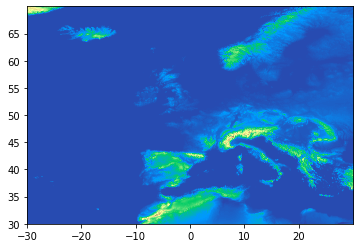

In [5]:
## Run the raster merge
merged_array, merged_transform = merge(datasets)

## Copy the meta data of the last tif file read in in the cell above
out_meta = file.meta.copy()
out_meta.update({"driver": "GTiff",
                  "height": merged_array.shape[1],
                  "width": merged_array.shape[2],
                  "transform": merged_transform,
                  }
                   )

## Output to a file to be read back in
out_path = '/Users/davidsykes/Downloads/merged_topog.tif'

with rasterio.open(out_path, "w", **out_meta) as dest:
    dest.write(merged_array)
    
topog_file = rasterio.open(out_path, 'r')
topog_data = topog_file.read()

## Plot to see it has worked
plt.imshow(topog_data[0], cmap='terrain', extent=topog_file.bounds)


### Read in gpx data of each day of the ride

The gpx data is downloaded from Strava. This is done by clicking Download GPX from an activity. 

In [6]:
gpx_paths = ['/Users/davidsykes/Downloads/Day_1_Bordeaux_to_Baneuil_.gpx',
             '/Users/davidsykes/Downloads/Day_2_Baneuil_to_Rocamadour_.gpx',
             '/Users/davidsykes/Downloads/Day_3_Rocamadour_to_Entraygues_.gpx',
             '/Users/davidsykes/Downloads/Day_4_Entraygues_to_Mende_.gpx',
             '/Users/davidsykes/Downloads/Day_5_Mende_to_St_Julien_de_Payrolas_.gpx',
             '/Users/davidsykes/Downloads/Day_6_St_Julien_de_Payrolas_to_Sault_.gpx',
             '/Users/davidsykes/Downloads/Day_7_Sault_to_Fox_Amphoux_.gpx',
            ]

def gpx2df(gpx):    
    data = gpx.tracks[0].segments[0].points

    ## Start Position
    start = data[0]
    ## End Position
    finish = data[-1]

    df = pd.DataFrame(columns=['lon', 'lat', 'alt', 'time'])
    points = [{'lon': point.longitude, 'lat' : point.latitude, 
                   'alt' : point.elevation, 'time' : point.time} for point in data]
    df = pd.DataFrame(points)
    df['time'] = df['time'].astype(str).str[:-6]
    df['time'] = pd.to_datetime(df['time'], dayfirst=True)
    return data, df

gpx_dfs = []
for path in gpx_paths:
    gpx_file = open(path, 'r')
    gpx = gpxpy.parse(gpx_file)
    data,df = gpx2df(gpx)
    gpx_dfs.append(df)

data = gpx.tracks[0].segments[0].points

### Calc gpx distances
GPX files only contain lat/lon and time. These functions translate lat/lon to distance in km 

In [7]:
def calc_distance(row):
    try:
        return geopy.distance.geodesic((row['lat'], row['lon']), 
                                   (row['next_lat'], row['next_lon'])).km
    except:
        return None
    
def add_distance_to_gpxdf(df):
    out_df = df.copy()
    out_df['next_lat'] = out_df['lat'].shift(-1)
    out_df['next_lon'] = out_df['lon'].shift(-1)
    out_df['distance_delta_km'] = out_df.apply(calc_distance, axis=1)
    out_df['distance_cum_km'] = out_df['distance_delta_km'].cumsum()
    return out_df.drop(['next_lat', 'next_lon'], axis=1)

gpx_dfs = [df.pipe(add_distance_to_gpxdf) for df in gpx_dfs]

### Read in city data

City locations are pulled from open street map. In the end this wasn't used and the start and end of the gpx routes used instead

In [8]:
# paris = osmnx.geocode_to_gdf('Paris')
# bordeaux = osmnx.geocode_to_gdf('Bordeaux')
# fa = osmnx.geocode_to_gdf('Fox-Amphoux')
# rocamadour = osmnx.geocode_to_gdf('Rocamadour')
# baneuil = osmnx.geocode_to_gdf('Baneuil')
# e_s_t = osmnx.geocode_to_gdf('Entraygues-sur-Truyère')
# mende = osmnx.geocode_to_gdf('Mende')
# s_j_p = osmnx.geocode_to_gdf('Saint-Julien-de-Peyrolas')
# s_j_p = osmnx.geocode_to_gdf('Saint-Julien-de-Peyrolas')
# sault = osmnx.geocode_to_gdf('Sault')
# fox = osmnx.geocode_to_gdf('Fox-Amphoux')


# cities = [bordeaux.centroid,
#           fa.centroid, 
#           rocamadour.centroid, 
#           baneuil.centroid, 
#           e_s_t.centroid, 
#           mende.centroid, 
#           s_j_p.centroid, 
#           sault.centroid, 
#           fox.centroid]



### Clip the topography file to just France using the country outline

In [10]:
## First get France from the countries geojson. France returns all of France's territories so
## you have to explode the results and pick the France mainland (found via trial and error)
france = countries[countries['ADMIN'] == 'France']
france_all = france.explode()
france_main = france_all.iloc[20:21]


## Mask French topography using the country outline
france_topog_array, france_topog_transform = msk.mask(topog_file, [mapping(france_main.iloc[0].geometry)], crop=True)

## Repeat setting anywhere with no-data to be 1m above the max topography. We will use this when we build the 
## colour map to set it to the right background colour

france_topog_array, france_topog_transform = msk.mask(topog_file, [mapping(france_main.iloc[0].geometry)], crop=True, 
                    nodata=np.max(france_topog_array)+1)

## Write out and read back in. This makes it easier to work with when plotting

france_topog_out_path = '/Users/davidsykes/Downloads/france_topog.tif'


france_out_meta = topog_file.meta.copy()
france_out_meta.update({"driver": "GTiff",
                  "height": france_topog_array.shape[1],
                  "width": france_topog_array.shape[2],
                  "transform": france_topog_transform,
                  }
                   )

france_out_meta

with rasterio.open(france_topog_out_path, "w", **france_out_meta) as dest:
    dest.write(france_topog_array)
    
france_topog_file = rasterio.open(france_topog_out_path, 'r')
france_topog_data = france_topog_file.read()

france_topog_file.bounds


/var/folders/vg/d0v3hs012h1bqv_grqksxb5w0000gn/T/ipykernel_81182/2892937617.py:4: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  france_all = france.explode()


BoundingBox(left=-4.791805555555555, bottom=42.32486111111112, right=8.208194444444445, top=51.091527777777785)

### Build colormap

Build a custom colour map to plot. The matplotlib LinearSegmentedColormap API is not intuitive.

You have to define gradients for each colour element of RGB. 

For each colour (e.g. red) we define a scale from 0 to 1 with the red saturation at each point along the scale. There are two numbers for the start and end saturation. To keep a continuous scale, keep the start and end saturation the same.

```'red': ((0.0, 0, 0), (0.6, 0.25, 0.25), (1.0, 1.0, 1.0)), ``` 

So this means that at 0 on the input variable we will have 0 red, at 0.6 on the input variable we will have 0.25 red and at1 on the input scale we'll have 1 red saturation 

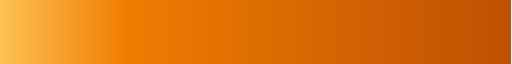

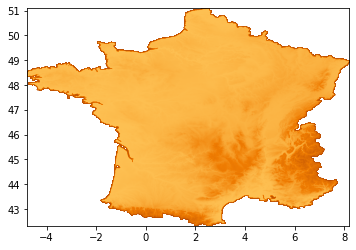

In [11]:
value_range = np.max(france_topog_array) - np.min(france_topog_array)

start_color = (255,194,84)
mid_color = (240,125,2)
end_color = (191,81,4)
mid_point = 0.25


### The colour scale ends at 0.999 and then we assign white to an input variable 
### value of 1 to make the out of range topography white like the background

c_dict = {
    'red': ((0.0, start_color[0]/256, start_color[0]/256), 
            (mid_point, mid_color[0]/256, mid_color[0]/256), 
            (0.999, end_color[0]/256, end_color[0]/256),
            (1.0, 1.0, 1.0)),
 'green': ((0.0, start_color[1]/256, start_color[1]/256),
            (mid_point, mid_color[1]/256, mid_color[1]/256), 
            (0.999, end_color[1]/256, end_color[1]/256),
           (1.0, 1.0, 1.0)),
 'blue': ((0.0, start_color[2]/256, start_color[2]/256),
            (mid_point, mid_color[2]/256, mid_color[2]/256), 
            (0.999, end_color[2]/256, end_color[2]/256),
          (1.0, 1.0, 1.0))
}

cmap1 = LinearSegmentedColormap(name='test', segmentdata=c_dict, N=value_range)
cmap1
plt.imshow(france_topog_data[0], extent=(france_topog_file.bounds.left, 
                                        france_topog_file.bounds.right,
                                        france_topog_file.bounds.bottom,
                                        france_topog_file.bounds.top), cmap=cmap1)
cmap1

### Extract points from gpx
Extract the start of the first day and end of the last day as well as end of each day as mid points of 
from the gpx files. These are used to plot the points on the map.

In [12]:
start = (gpx_dfs[0].iloc[0].lat, gpx_dfs[0].iloc[0].lon)
end = (gpx_dfs[-1].iloc[-1].lat, gpx_dfs[-1].iloc[-1].lon)
start_end = [start, end]
midways = [(df.iloc[-1].lat, df.iloc[-1].lon) for df in gpx_dfs[:-1]]

### Plot France

Pull the final map plot together.

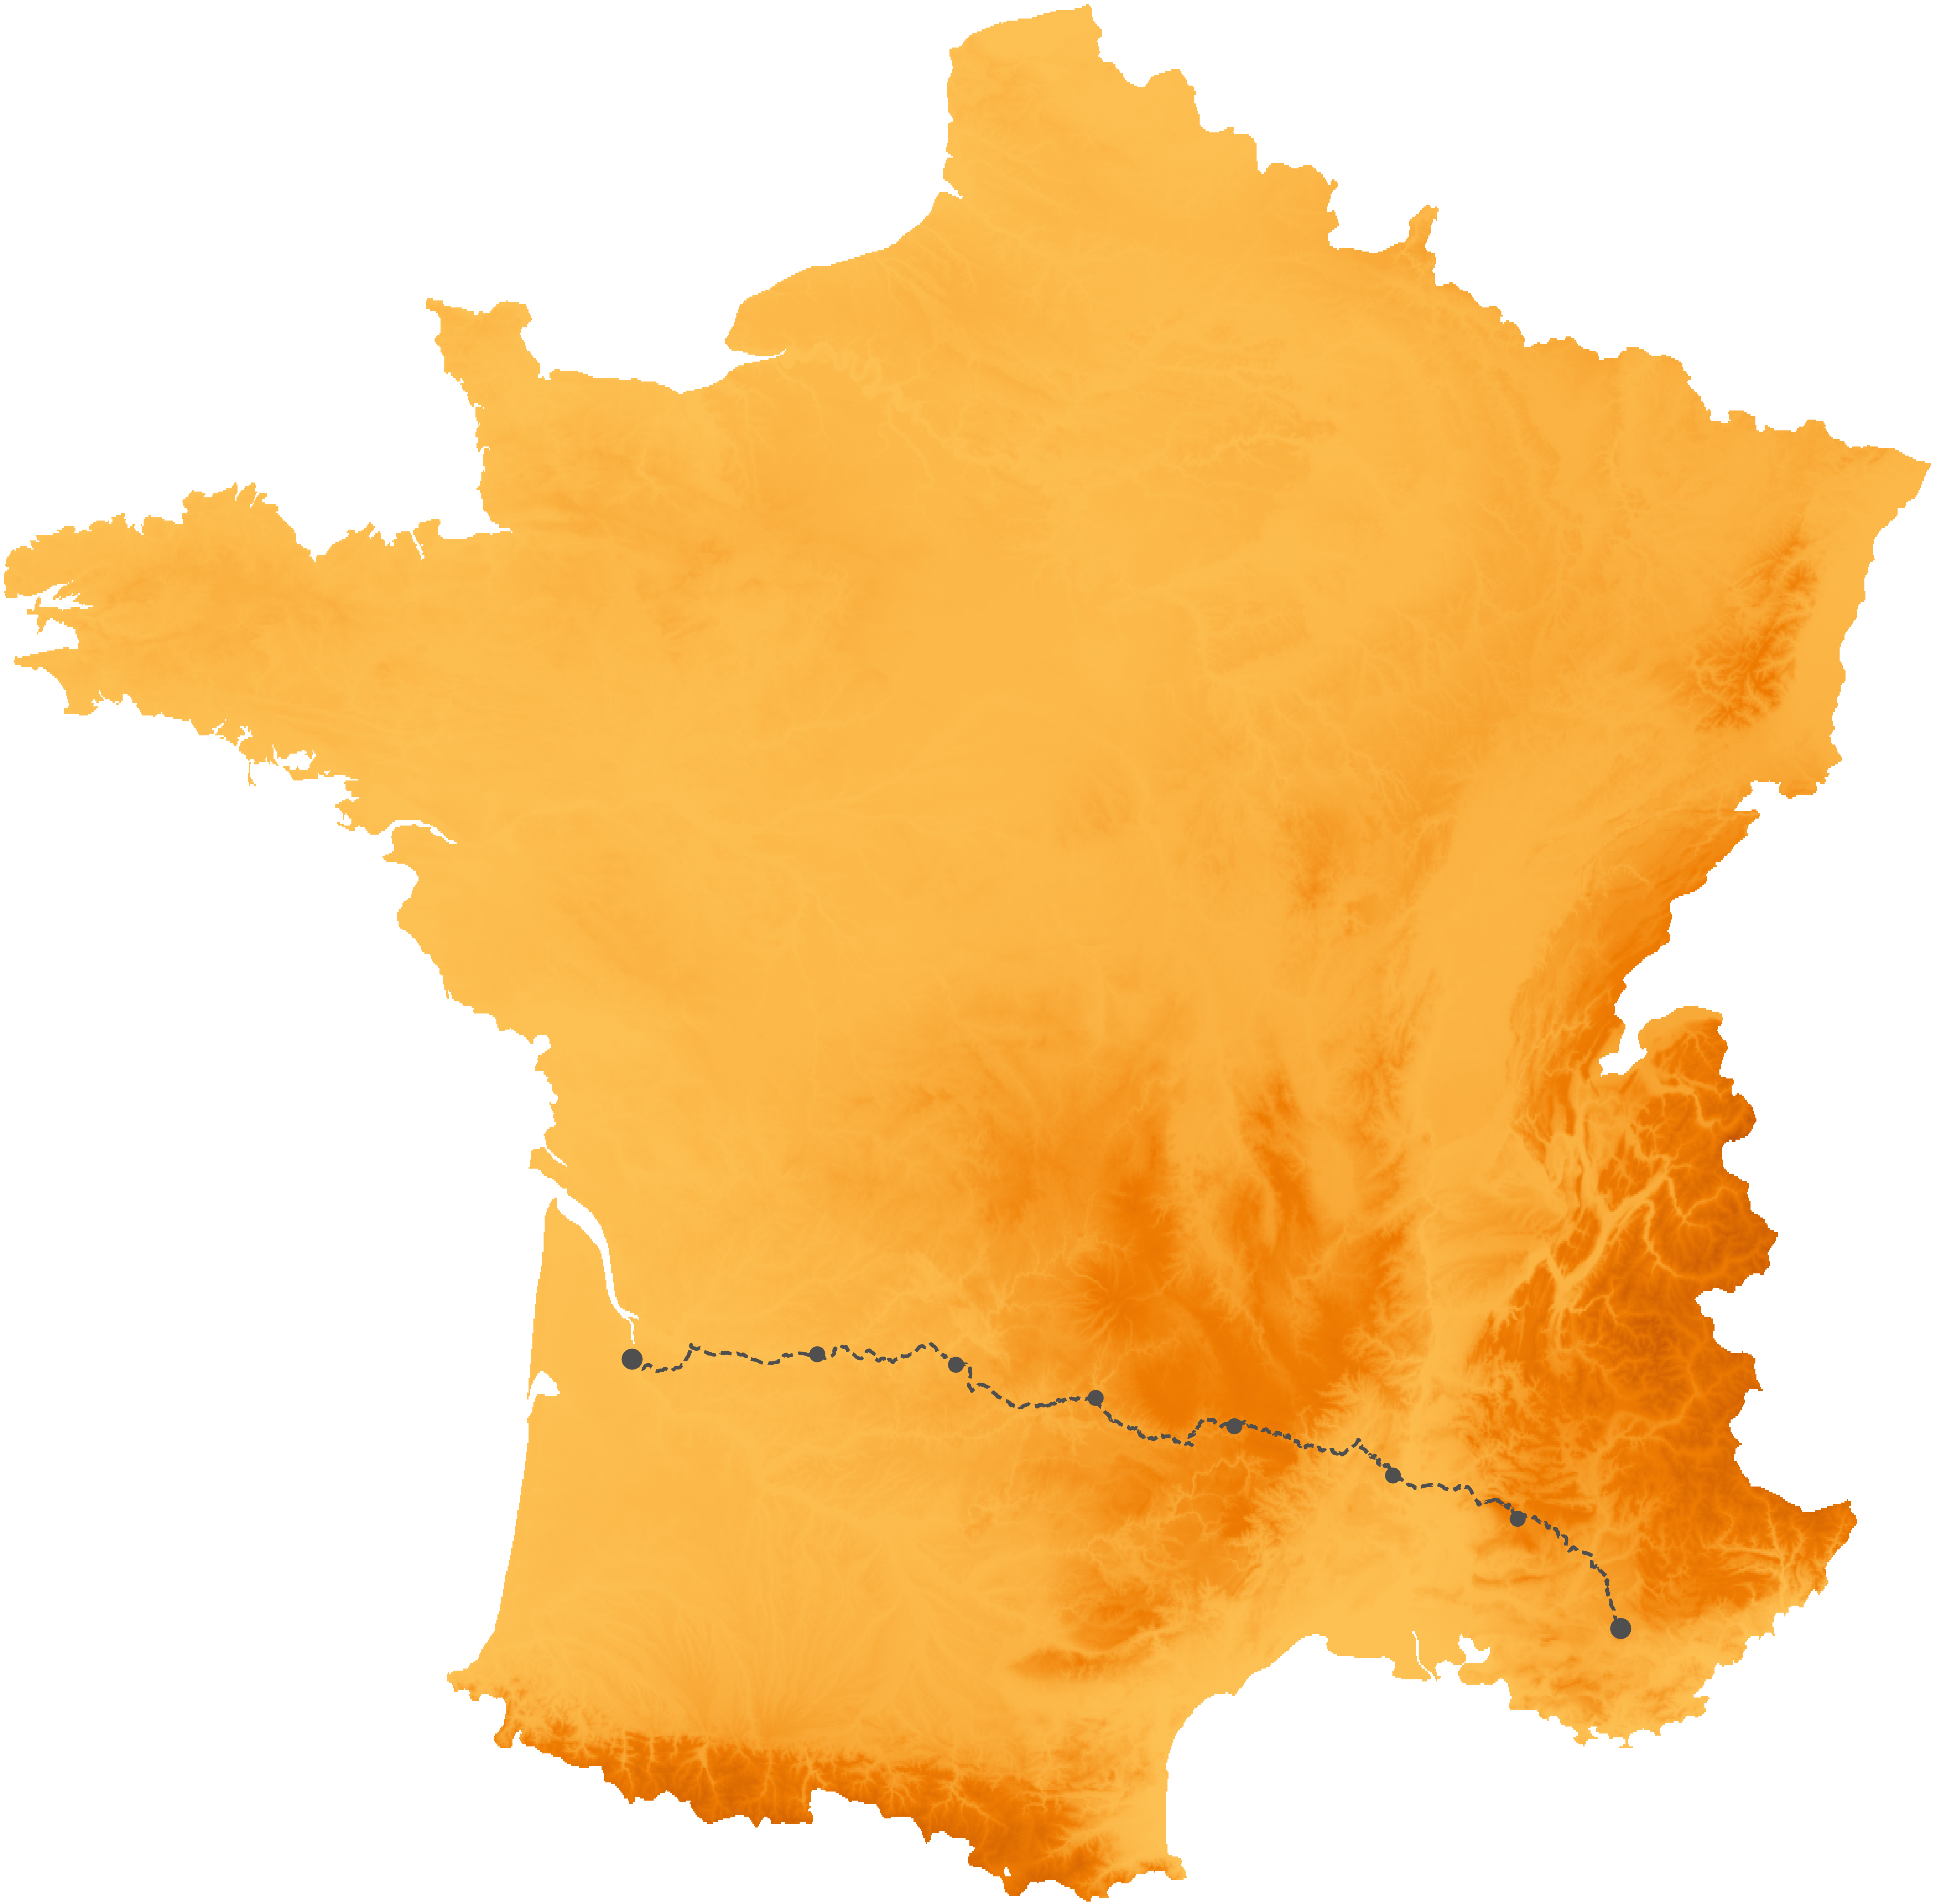

In [13]:
## Create figure
fig, ax = plt.subplots(1, figsize=(100,100))

## Plot the topography data (using the bounds from the file itself)
ax.imshow(france_topog_data[0], extent=(france_topog_file.bounds.left, 
                                        france_topog_file.bounds.right,
                                        france_topog_file.bounds.bottom,
                                        france_topog_file.bounds.top), cmap=cmap1)

## This step is a bit of a bodge. We plot the country outline but with no colour. This is done because
## it makes matplotlib realise it is a map plot and scales the plot appropriately. There is probably a better way
## to do this
france_main.plot(edgecolor='none', facecolor='none', lw=1, ax=ax)


## Plot each route as a line
for df in gpx_dfs:
    df[['lat','lon']].plot(x='lon', y='lat', ax=ax, color='#4f4f4f', ls='--', lw=10)
    


# Plot start and end points as larger dots
ax.scatter(x=[pt[1] for pt in start_end], y=[pt[0] for pt in start_end], color='#4f4f4f', s=3500, zorder=2)

# Plot the midpoints as smaller dots
ax.scatter(x=[pt[1] for pt in midways], y=[pt[0] for pt in midways], color='#4f4f4f', s=2000, zorder=2)

#Remove axes and set legend and margins
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
ax.margins(x=0)
ax.margins(y=0)
ax.get_legend().remove()
fig.patch.set_visible(False)
ax.axis('off')

plt.savefig('/Users/davidsykes/Downloads/final_map.png')


### Plot the topography
Using the gpx data from Strava, plot the combined topography of the ride

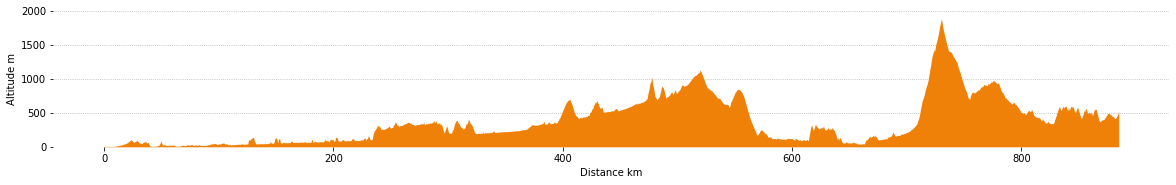

In [14]:
# Concatenate all the gpx routes together
combined_gpx = pd.concat(gpx_dfs, axis=0)

# Calculate cumulative distance
combined_gpx['distance_cum_km'] = combined_gpx['distance_delta_km'].cumsum()
combined_gpx = combined_gpx.dropna(subset=['distance_cum_km'])

# Plot the altitude vs cumulative distance
ax = combined_gpx.plot.area(x='distance_cum_km',
                       y='alt',
                       figsize=(20,2.5),
                      color='#ef8109',
                        lw=0)


plt.box(None)
ax.set_xlabel('Distance km')
ax.set_ylabel('Altitude m')

ax.set_ylim((0,2000))
ax.grid(axis='y', linestyle=':')
ax.set_axisbelow(True)
ax.get_legend().remove()

plt.savefig('/Users/davidsykes/Downloads/final_profile.png', bbox_inches = "tight")
